# Analysis of in-situ radiography measurements - PART 2
Last update: 14.10.2024

# Aims

- Process in-situ tensile test radiographs
- Use Digital Image Correlation to calculate strain field within the palm leaf

# TO DO
- [X] Segment leaf and remove background
- [X] Equalize background (vertical gradient)
- [ ] From displacement to strain field
- [ ] Script iterating across all supra-frames

## Mechanical test results
- [ ] find t_0 on radiographs
- [ ] stiffness (linear fit F-u curve)
- [ ] stiffness (linear fit F vs DIC displacements)

# *Computational workflow*

## Part 1:
1. Load and crop active portion of in-situ test
    - start radiograph: 3700
    - end radiograph: 6700
    - step between radiographs: 2
    - frame rate: ~84 fps
    - crop around leaf
    - dataset size: 1500 x 1618 x 1450
 2. Save as separate .H5 file

## Part 2:
1. Load preprocessed radiographs from step 1
2. Average 5 radiographs each 100 (SUPRA-FRAME)
3. flat field correct
4. equalize background
5. write as stack of `.TIFF`

## Part 3:
1. SPAM DIC: initial displacement guess and register
2. SPAM DIC: DIC analysis
3. SPAM DIC: Strain field analysis
4. Loop across all supra-frames

## Imports and configuration

In [6]:
# default imports
import os
import dxchange
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

astropy module not found
olefile module not found


In [7]:
# matplotlib plotting parameters
mpl.rcParams['figure.dpi'] = 300
mpl.rc('image', cmap='gray')
plt.style.use('ggplot')

mpl.style.use("dark_background")
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["image.interpolation"] = "bicubic"
mpl.rcParams["image.cmap"] = "Greys_r"
mpl.rcParams["figure.figsize"] = (8,6)

### Function definition

In [8]:
def normalize(im, flat, dark):
    im = im.astype('float32')
    flat = np.median(flat, axis=0).astype('float32')
    dark = np.median(dark, axis=0).astype('float32')

    return (im - dark) / (flat - dark)

## Load in-situ radiography experiment data
- On Terminus:

In [4]:
# sample_name = "palm_leaf_tensile_11_far-20240926T135239"
# # work_dir = os.path.join("/", "PETRA", "SED", "BEATS", "IH", "2024", "khasahwnh")

# # work_dir = '/usr/terminus/data-xrm-01/stamplab/measurements/BEATS/20240923_IH_palm_leaf/in-situ_radiography/'
# work_dir = '/Volumes/stamplab_terminus/measurements/BEATS/20240923_IH_palm_leaf/in-situ_radiography/'
# h5file = os.path.join(work_dir, sample_name, f'{sample_name}.h5')

# flats_file = "palm_leaf_tensile_11_far_FLAT_DARK-20240926T141726"
# h5file_flats = os.path.join(work_dir, flats_file, f'{flats_file}.h5')

# results_dir = '/Volumes/stamplab_terminus/processed/BEATS/20240923_IH_palm_leaf/in-situ_radiography/'
# # results_dir = '/usr/terminus/data-xrm-01/stamplab/processed/BEATS/20240923_IH_palm_leaf/in-situ_radiography/'

- Local:

In [9]:
sample_name = "palm_leaf_tensile_11_far-20240926T135239"

work_dir = '/Users/gianthk/Data/20240923_IH_palm_leaf/in-situ_radiography/'
h5file = '/Users/gianthk/Data/20240923_IH_palm_leaf/in-situ_radiography/palm_leaf_tensile_11_far-20240926T135239/palm_leaf_tensile_11_far-20240926T135239_3700to6700.h5'

flats_file = "palm_leaf_tensile_11_far_FLAT_DARK-20240926T141726"
h5file_flats = '/Users/gianthk/Data/20240923_IH_palm_leaf/in-situ_radiography/palm_leaf_tensile_11_far_FLAT_DARK-20240926T141726/palm_leaf_tensile_11_far_FLAT.h5'
h5file_darks = '/Users/gianthk/Data/20240923_IH_palm_leaf/in-situ_radiography/palm_leaf_tensile_11_far_FLAT_DARK-20240926T141726/palm_leaf_tensile_11_far_DARK.h5'

results_dir = '/Users/gianthk/Data/20240923_IH_palm_leaf/in-situ_radiography/results'

## Load already cropped portions of FLATS and DARKS .H5 file
Slicing parameters used:
- > slc_1500 = ((3700, 6700, 2), (482, 2100, 1), (500, 1950, 1))
- > slc_flats = ((50, 101, 1), (482, 2100, 1), (500, 1950, 1))


In [ ]:
# flats = dxchange.reader.read_hdf5(h5file_flats, '/exchange/data', slc=slc_flats, dtype=None, shared=False)
# darks = dxchange.reader.read_hdf5(h5file_flats, '/exchange/data', slc=slc_flats, dtype=None, shared=False)

flats = dxchange.reader.read_hdf5(h5file_flats, '/exchange/data', dtype=None, shared=False)
darks = dxchange.reader.read_hdf5(h5file_darks, '/exchange/data', dtype=None, shared=False)

In [40]:
print("Flat fields size: ", flats[:, :, :].shape[:])
print("Dark fields size: ", darks[:, :, :].shape[:])

Flat fields size:  (51, 1618, 1450)
Dark fields size:  (51, 1618, 1450)


Text(0.5, 1.0, 'darks')

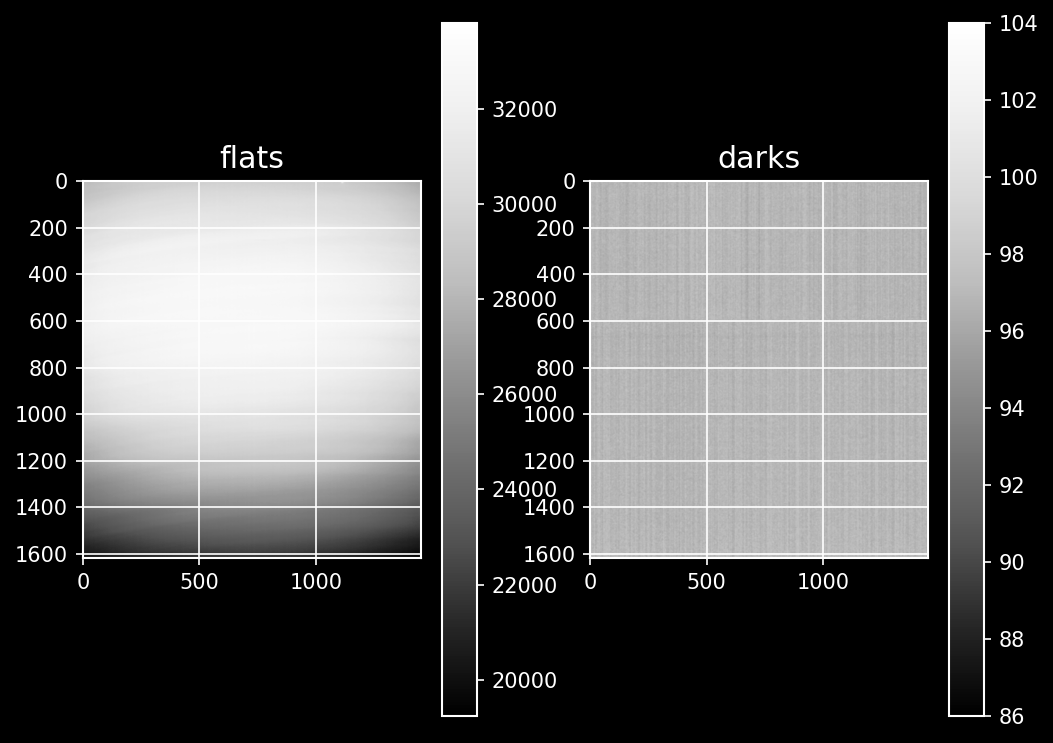

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(np.median(flats, axis=0))
plt.colorbar()
plt.title('flats')
plt.subplot(1, 2, 2)
plt.imshow(np.median(darks, axis=0))
plt.colorbar()
plt.title('darks')

## Load and process chunks of pre-processed radiography stack
Config and initialize processed radiogaph array

In [56]:
slc_start = 0
slc_t = 5 # the number of projections to average
slcAtoB = 100 # the step between two consecutive steps read
rad_length = 1500

proj_processed = np.zeros((int(rad_length / slcAtoB), flats.shape[1], flats.shape[2]))

In [57]:
count = 0
for slc_start in range(0, rad_length, slcAtoB):
    # load
    slc_A = ((slc_start, slc_start+slc_t, 1), (0, None, 1), (0, None, 1))
    proj_A = np.mean(dxchange.reader.read_hdf5(h5file, '/exchange/data', slc=slc_A, dtype=np.float32, shared=False), axis=0)

    # normalize
    proj_processed[count,:,:] = normalize(proj_A, flats, darks)
    count += 1

Text(0.5, 1.0, 't2-t1')

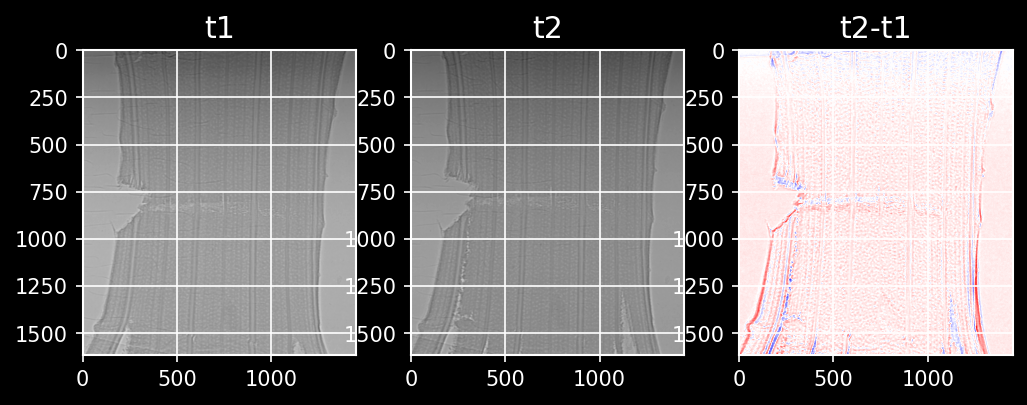

In [68]:
plt.subplot(1, 3, 1)
plt.imshow(proj_processed[0,:,:])
# plt.colorbar()
plt.title('t1')
plt.subplot(1, 3, 2)
plt.imshow(proj_processed[-1,:,:])
# plt.colorbar()
plt.title('t2')
plt.subplot(1, 3, 3)
plt.imshow((proj_processed[0,:,:] - proj_processed[-1,:,:]), cmap='seismic')
# plt.colorbar()
plt.title('t2-t1')

## Equalize background
Still partial inhomogeneity after flat field-correction

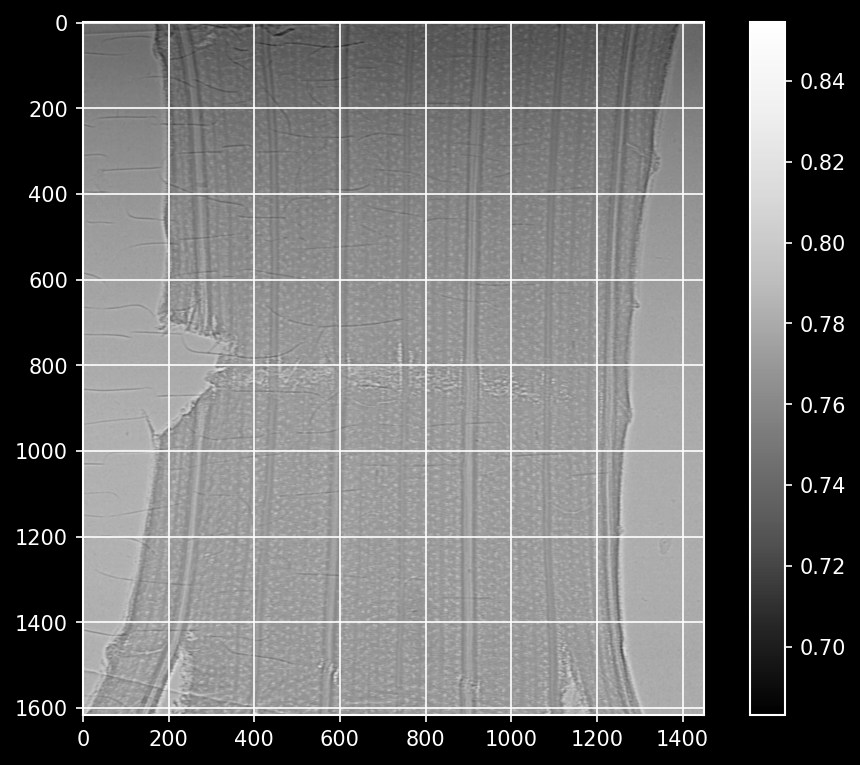

In [71]:
plt.imshow(proj_processed[5,:,:])
plt.colorbar()

In [79]:
background_mean = np.mean(proj_processed, axis=(0,2))
background_X = np.arange(0, len(background_mean), 1)

In [84]:
# Fit a polynomial of degree X
degree = 3
coefficients = np.polyfit(background_X, background_mean, degree)

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Generate y-values from the polynomial
background_fit = polynomial(background_X)


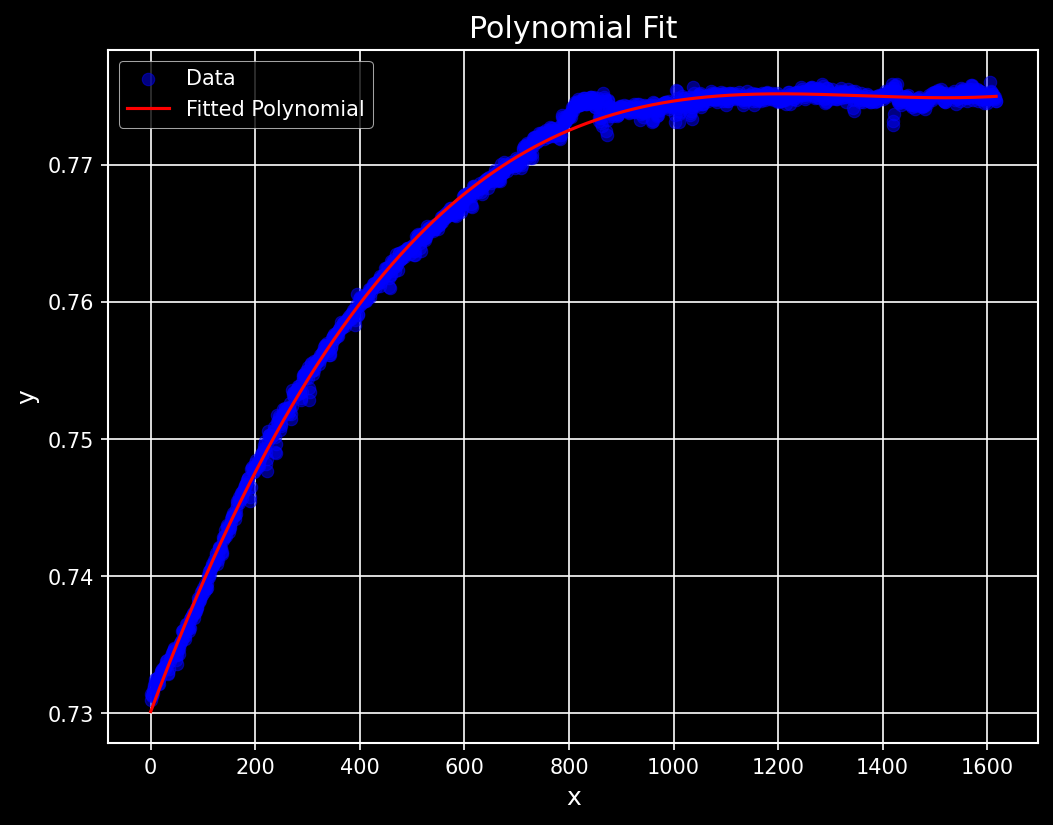

In [85]:
# Plot the original data and the fitted polynomial
plt.scatter(background_X, background_mean, label='Data', color='blue', alpha=0.5)
plt.plot(background_X, background_fit, label='Fitted Polynomial', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Fit')
plt.legend()
plt.show()

### Tile the fit to create an equalization mask

In [97]:
background_mask = np.swapaxes(np.tile(background_fit, (proj_processed.shape[0], proj_processed.shape[2], 1)), 1, 2)
print(background_mask.shape)
print(proj_processed.shape)
print(proj_processed.dtype)

(15, 1618, 1450)
(15, 1618, 1450)
float64


In [98]:
proj_processed_eq = proj_processed / background_mask

Text(0.5, 1.0, 'processed; equalized')

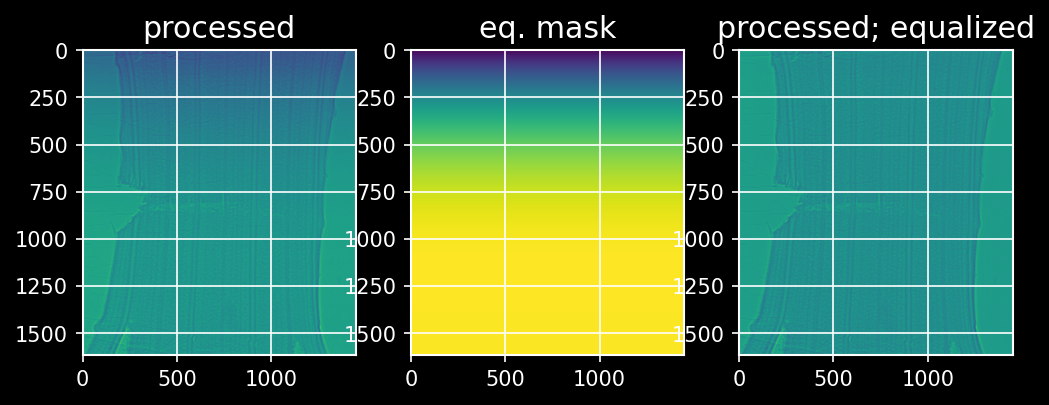

In [99]:
plt.subplot(1, 3, 1)
plt.imshow(proj_processed[0,:,:], cmap='viridis')
# plt.colorbar()
plt.title('processed')
plt.subplot(1, 3, 2)
plt.imshow(background_mask[0,:,:], cmap='viridis')
# plt.colorbar()
plt.title('eq. mask')
plt.subplot(1, 3, 3)
plt.imshow(proj_processed_eq[0,:,:], cmap='viridis')
# plt.colorbar()
plt.title('processed; equalized')

### Save normalized frames as a stack of `.TIFF` images

In [100]:
processed_tiff_name = 'averaged_and_normalized_and_equalized'
processed_tiff_stack = os.path.join(results_dir, processed_tiff_name, f'step.tiff')

In [101]:
dxchange.writer.write_tiff_stack(proj_processed_eq, processed_tiff_stack, digit=4, axis=0, start=0, overwrite=True)

spam-pixelSearch \                                      # the script
            /path/to/my/data/im1.tif /path/to/my/data/im2.tif \  # the two 3D or 2D images (tiff files) to correlate
            -mf1 /path/to/my/data/mask1.tif -mc 0.5 \            # the mask of im1 and the coverage to skip the subvolumes
            -pf /path/to/my/data/initialPhi.tsv -pfb 2 \         # initial guess, which was run in half-sized images
            -ns X -hws X \                                       # node spacing and half window size of the grid
            -sr -Z Z -Y Y -X X \                                 # search range
            -tif -vtk                                            # ask for tif and vtk output

## Perform Digital Image Correlation with SPAM
### STEP 1 - `spam-reg`

> spam-reg step_0011.tiff step_0012.tiff -it 200 

### STEP 2 (not used) - `spam-pixelSearch`

> spam-pixelSearch proj_3700_norm.tiff proj_6700_norm.tiff -ns 10 -hws 25 -sr -1 1 -55 55 -30 30 -tif

> spam-pixelSearch proj_4700_norm.tiff proj_6700_norm.tiff -ns 8 -hws 25 -sr -1 1 -25 25 -20 20 -tif

### STEP 3 - `spam-ldic`

> spam-ldic step_0011.tiff step_0012.tiff -pf step_0011-step_0012-registration.tsv -ns 5 -hws 20 -it 80 -tif

> spam-ldic step_0006.tiff step_0007.tiff -pf step_0006-step_0007-registration.tsv -mf1 ./../DIC_mask2.tif -ns 5 -hws 20 -it 80 -tif